# SpectralClustering

In [1]:
from eden.converter.graph.gspan import gspan_to_eden
from eden.graph import Vectorizer
graphs = gspan_to_eden( 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan' )
vectorizer = Vectorizer( r=2,d=5 )
datasetBursi = vectorizer.transform( graphs )

Automatically created module for IPython interactive environment
y_pred:  [0 0 0 ..., 0 0 0]
Size y:  0
Size X:  4337
Size X[1]:  1048577
y_pred:  [0 0 0 ..., 0 0 0]
Size y:  0
Size X:  4337
Size X[1]:  1048577


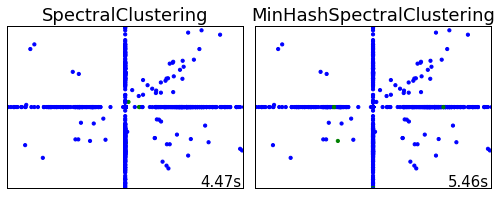

Accuracy of prediction:  0.986857274614
spectral clusters count:  [[0, 4314], [1, 23]]
minHash clusters count:  [[0, 4295], [1, 42]]


In [47]:
%matplotlib inline
print(__doc__)

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import SparseRandomProjection

from neighborsMinHash.clustering import MinHashSpectralClustering 


np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'SpectralClustering', 'MinHashSpectralClustering']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

datasets = [noisy_circles, noisy_moons, blobs, no_structure]
#for i_dataset, dataset in enumerate(datasets):
#X, y = dataset
X = datasetBursi
y = None
# normalize dataset for easier parameter selection
#X = StandardScaler().fit_transform(X)

# estimate bandwidth for mean shift
#bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# create clustering estimators
#ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=2)
ward = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward',
                                       connectivity=connectivity)
spectral = cluster.SpectralClustering(n_clusters=2,
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors", n_neighbors=4)
minHashSpectral = MinHashSpectralClustering(n_clusters=2,
                                      eigen_solver='arpack', n_neighbors=4)

dbscan = cluster.DBSCAN(eps=.2)
affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                   preference=-200)

average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock", n_clusters=2,
    connectivity=connectivity)

birch = cluster.Birch(n_clusters=2)
# clustering_algorithms = [
#     two_means, affinity_propagation, spectral, minHashSpectral, ward, average_linkage,
#     dbscan, birch]
clustering_algorithms=[spectral, minHashSpectral]

#print "X: ", X
list_y = []
#data_projection = SparseRandomProjection(n_components=1, random_state=1)
# for i in xrange(X.shape[0]):
#     data_projection = SparseRandomProjection(n_components=1, random_state=1)
#     list_y.append([data_projection.fit_transform(X.getrow(i)).getnnz()])
# print "DataTransformed: ", list_y

data_projection = SparseRandomProjection(n_components=2, random_state=1)
data_transformed = data_projection.fit_transform(X)
#print data_transformed
x = []
y = []

for datapoint in data_transformed:
    x.append(datapoint[0,0])
    y.append(datapoint[0,1])
    
result = []
for name, algorithm in zip(clustering_names, clustering_algorithms):
    # predict cluster memberships
    t0 = time.time()
    algorithm.fit(X)
    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
    print "y_pred: ", y_pred
    result.append(y_pred)
    # plot
    plt.subplot(4, len(clustering_algorithms), plot_num)
    #if i_dataset == 0:
        
    plt.title(name, size=18)
#     print "X[:, 0]", X[:, 0]
#     print "X[:, 1]", X[:, 1]
#     print "colors: ", colors
#     print 'colors[y_pred]: ', colors[y_pred]
#     print "colors[y_pred].tolist(): ", colors[y_pred].tolist
    print "Size y: ", len(list_y)
    print "Size X: ", X.shape[0]
    print "Size X[1]: ", X.shape[1]
    plt.scatter(x, y, color=colors[y_pred].tolist(), s=10)

#     if hasattr(algorithm, 'cluster_centers_'):
#         centers = algorithm.cluster_centers_
#         center_colors = colors[:len(centers)]
#         plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1

plt.show()

print "Accuracy of prediction: ", accuracy_score(result[0], result[1])
print "spectral clusters count: ", [[x,result[0].tolist().count(x)] for x in set(result[0])]
print "minHash clusters count: ", [[x,result[1].tolist().count(x)] for x in set(result[1])]